### 

<div style="text-align:center;">
    <h2>cda2/4Da Policy Advices zur Energieerzeugung ohne Treibhausgasausstoss</h2>
    <p>Marius Läubli, Weiping Zhang</p>
    <p>Data Science Bachelor Program, FHNW</p>
    <p>JUNE 2023</p>
</div>


- This notebook includes how we connect (data source), modify, aggregate all final data which are used in our dashboard and story telling report.
- All the data are queried by API, as long as the connections still work, we could simply run over the whole notebook to get the 
data and our interactive dashboard updated in a few minutes.
- Data source: rte-France, smard, terna, admin.ch

## 0 Building Notebook environment

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import requests
import json
from openpyxl import load_workbook
import xml.etree.ElementTree as ET
from requests.auth import HTTPBasicAuth
from datetime import datetime, timedelta
from openpyxl.utils import get_column_letter, column_index_from_string
import time
from dotenv import load_dotenv
import traceback

In [2]:
# Log Handling
log_file = './log/main.log'
if os.path.exists(log_file):
    os.remove(log_file)

# define log function for logging
def addlog(cat, pstr):
    s = cat + str(datetime.now())[0:19] + '|' + pstr
    print(s)
    with open(log_file, 'a') as f:
        f.write(s + '\n')
    return

# define log function for info

def addinfo(pstr):
    s = 'LOG|INFO|' + str(datetime.now())[0:19] + '|' + pstr
    print(s)
    with open(log_file, 'a') as f:
        f.write(s + '\n')
    return

# define log function for error
def adderror(pstr):
    s = 'LOG|ERROR|' + str(datetime.now())[0:19] + '|' + pstr
    print(s)
    with open(log_file, 'a') as f:
        f.write(s + '\n')
    return

In [3]:
# Load Credentials
try: 
    denv = load_dotenv(dotenv_path='./main.env')
    if denv:
        addinfo('Credentials file found')
    else:
        adderror('Credentials file not found ' + traceback.format_exc())
    rte_client_id = os.getenv('RTE_CLIENT_ID')
    rte_client_secret = os.getenv('RTE_CLIENT_SECRET')
    terna_client_id = os.getenv('TERNA_CLIENT_ID')
    terna_client_secret = os.getenv('TERNA_CLIENT_SECRET')
    addinfo('Credentials loaded')
except:
    adderror('Credentials not loaded ' + traceback.format_exc())

LOG|INFO|2023-06-11 19:08:32|Credentials file found
LOG|INFO|2023-06-11 19:08:32|Credentials loaded


## 1 Life-cycle greenhouse gas emissions of energy sources

- We use the life cycle CO2 emissions per kWh mainly from IPCC 2014, rte, UNECE 2020.
### 1.1 Source
#### 1.1.1 rte-France
- The contribution of each energy source to C02 emissions is as follows:

    - 0.986 t CO2 eq /MWh for coal-fired plants
    - 0.777 t CO2 eq /MWh for oil-fired plants
    - 0.429 t CO2 eq /MWh for gas-fired plants
    - 0.494 t CO2 eq /MWh for biofuel plants (waste)
    - 0.486 t CO2 eq /MWh for gas-turbine plants
    - 0.352 t CO2 eq /MWh for co-generation & combined-cycle plants
    - 0.583 t CO2 eq /MWh for other gas-fired plants
    - 0.494 t CO2 eq /MWh for household waste
    - For energy sources that are not mentioned, their contribution to CO2 emissions is considered equal to 0 t CO2 eq / MWh. 
- https://www.rte-france.com/en/eco2mix/co2-emissions
    
#### 1.1.2 Lifecycle CO2 emissions per kWh from IPCC 2014 & UNECE 2020 (EU28 countries):
- List of acronyms:
    - PC — pulverized coal
    - CCS — carbon capture and storage
    - IGCC — integrated gasification combined cycle
    - SC — supercritical
    - NGCC — natural gas combined cycle
    - CSP — concentrated solar power
    - PV — photovoltaic power
- https://en.wikipedia.org/wiki/Life-cycle_greenhouse_gas_emissions_of_energy_sources#cite_note-:0-5

#### 1.1.3 trusted unnamed source
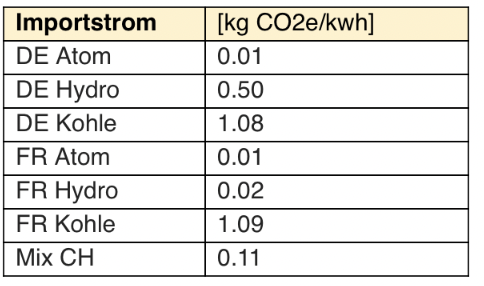

### 1.2 generate co2 intensity table

In [4]:
# CO2 intensity; 
# unit: gCO2eq/kWh
co2_intensity = pd.DataFrame()
co2_intensity['technology'] = ['coal','natural gas','other renewables','oil','biomass','solarPV rooftop',
                          'solarPV utilityscale','solarPV rooftop&utilityscale','solarPV concentrated',
                          'solarPV polySi ground-mounted', 'solarPV polySi roof-mounted',
                          'geothermal','hydro','wind offshore','wind onshore','nuclear',
                          'waste','ocean','other conventional','de nuclear','de hydro','de coal', 'fr nuclear', 'fr hydro', 'fr coal']
co2_intensity['median'] = [820,490,400,777,230,41,48,44.5,27,37,37,38,24,12,12,12,494,17,645, 10, 500, 1080, 10, 20, 1090]
co2_intensity

,technology,median
0,coal,820.0
1,natural gas,490.0
2,other renewables,400.0
3,oil,777.0
4,biomass,230.0
5,solarPV rooftop,41.0
6,solarPV utilityscale,48.0
7,solarPV rooftop&utilityscale,44.5
8,solarPV concentrated,27.0
9,solarPV polySi ground-mounted,37.0


## 2 actual electricity generation
### 2.1 France: electricity actual generation data from rte
- available earliest from 2015-01-01, has a limit for the timespan per request, which is why it's looped
- hourly data

#### 2.1.1 query data 

In [5]:
# Getting the token from RTE
try:
    # This is the URL to get  the token
    oauthurl = "https://digital.iservices.rte-france.com/token/oauth"

    # These are the credentials to get the token
    client_id = rte_client_id
    client_secret = rte_client_secret
    # This is the payload to get the token
    auth = HTTPBasicAuth(client_id, client_secret)
    response = requests.get(oauthurl, auth=auth)
    # Check response status code
    if response.status_code == 200:
        # If the response is OK, get the token from the response
        data = response.json()
        token = data['access_token']
        addinfo('Token received')
    else:
        adderror("Error: "+ response.status_code + " " + response.reason)
        #  
    headers = {
        "Authorization": "Bearer " + token}
except:
    adderror('Error while getting data from RTE ' + traceback.format_exc())
    #  

LOG|INFO|2023-06-11 19:08:32|Token received


In [6]:
# This is the URL to get the data
url = "https://digital.iservices.rte-france.com/open_api/actual_generation/v1/actual_generations_per_production_type"
try:
    def generate_date_list(start_year, start_month):
        start_date = datetime(year=start_year, month=start_month, day=1)
        end_date = datetime.now()
        date_list = []
        while start_date <= end_date:
            date_list.append(start_date.strftime('%Y-%m-%dT%H:%M:%S+01:00'))
            start_date += timedelta(days=31)
        return date_list

    def rte_data(start_year, start_month, url, token, output_path_name):
        '''
        give a csv file with actual generations per production type from start_year, start_month till now
        ------
        INPUT:
        - start_year, start_month: earliest 2015,01 
        - the data is updated for each hour (interval = 1 hour)
        ------
        OUTPUT:
        - a csv file with four columns of ['production_type', 'start_date', 'end_date', 'value']
        - this csv file will also be saved locally 
        '''
        date_lst = generate_date_list(start_year, start_month)
        df_final = pd.DataFrame()   
        headers = {
                "Authorization": "Bearer " + token}
        for i in range(len(date_lst)-1):
            
            params = {
            "start_date": date_lst[i],
            "end_date": date_lst[i+1],}
            response = requests.get(url, headers=headers, params=params)

            if response.status_code == 200:
                rte_json = response.json()
                df = pd.DataFrame()
                for generation in rte_json['actual_generations_per_production_type']:
                    production_type = generation['production_type']
                    for value in generation['values']:
                        row = {'production_type': production_type,
                            'start_date': value['start_date'],
                            'end_date': value['end_date'],
                            'value': value['value']}
                        df = df.append(row, ignore_index=True)
                # append to the final df
                df_final = pd.concat([df_final, df], ignore_index=True)

            else:
                print("Error:", response.status_code, response.text)
        df_final.to_csv(output_path_name) # save the data
        return df_final
    addinfo('RTE Function defined')
except:
    adderror('Error while defining RTE function ' + traceback.format_exc())
    #  


LOG|INFO|2023-06-11 19:08:32|RTE Function defined


In [7]:
dataload = False
# THIS STEP IS TO GENERATE complete electricity generation data from France.
# It is very time consuming, so we save the data locally and load it directly in the next step.
# Uncomment the following lines to run the function
'''
try:
    rte_2015_2023 = rte_data(2015, 1, url,token,'../Data/rte_fr_generation_2015_2023.csv')
    dataload = True
    addinfo('RTE data loaded and updated')
except:
    adderror('Error while loading RTE data ' + traceback.format_exc())
    #  
'''

"\ntry:\n    rte_2015_2023 = rte_data(2015, 1, url,token,'../Data/rte_fr_generation_2015_2023.csv')\n    dataload = True\n    addinfo('RTE data loaded and updated')\nexcept:\n    adderror('Error while loading RTE data ' + traceback.format_exc())\n    #  \n"

In [8]:
# in unit MWh electricity every hour from earliest 2015.01
try:
    if dataload == False:
        rte_2015_2023 = pd.read_csv('../Data/rte_fr_generation_2015_2023.csv', sep=',')[['production_type', 'start_date', 'end_date', 'value']]
        addinfo('RTE data loaded from local file')
    rte_2015_2023
except:
    adderror('Error while loading RTE data ' + traceback.format_exc())
      

LOG|INFO|2023-06-11 19:08:33|RTE data loaded from local file


#### 2.1.2 add corresponding CO2 intensity

-  HYDRO_PUMPED_STORAGE is negative, because it is a method of storing energy by pumping water uphill to a reservoir when excess electricity is available, and then releasing the water back down to generate electricity when demand is higher. Since no fuel is burned to generate this electricity, there is effectively zero carbon dioxide emitted. In fact, the process can actually result in a negative carbon footprint, as it can help to balance out the intermittency of other renewable energy sources like wind and solar, reducing the need for backup power from fossil fuel sources.
-  the most often used technology for generating solar energy is solar PV - rooftop

In [9]:
try:
       # map production_type to a new column tech
       production_type = ['BIOMASS', 'FOSSIL_GAS', 'FOSSIL_HARD_COAL', 'FOSSIL_OIL',
              'HYDRO_PUMPED_STORAGE', 'HYDRO_RUN_OF_RIVER_AND_POUNDAGE',
              'HYDRO_WATER_RESERVOIR', 'NUCLEAR', 'SOLAR', 'WASTE',
              'WIND_ONSHORE']
       # corresponding type names in co2_intensity table
       source = ['biomass', 'natural gas', 'fr coal', 'oil','fr hydro','fr hydro','fr hydro','fr nuclear','solarPV rooftop','waste','wind onshore']
       # new column to map source names
       mapping_dict_fr = dict(zip(production_type, source))
       rte_2015_2023_types = rte_2015_2023.copy()
       rte_2015_2023_types['source'] = rte_2015_2023_types['production_type'].map(mapping_dict_fr)
       # add gCO2eq/kWh (by production type) to indicate co2 emission per unit electricity generation
       rte_2015_2023_types = pd.merge(rte_2015_2023_types, co2_intensity, left_on='source', right_on='technology', how='left').rename(columns={'median': 'gCO2eq/kWh'}).drop('technology',axis=1)

       total = rte_2015_2023_types[rte_2015_2023_types['production_type']=='TOTAL']
       rte_2015_2023_types = rte_2015_2023_types[rte_2015_2023_types['production_type']!='TOTAL']
       # add total co2 emission for each row
       rte_2015_2023_types['gco2eq'] = rte_2015_2023_types['value']*1000*rte_2015_2023_types['gCO2eq/kWh']
       # rte_2015_2023_types.to_csv('../Data/rte_2015_2023_types.csv')

       total_co2 = rte_2015_2023_types.groupby(['start_date','end_date']).sum().reset_index()[['start_date','end_date','gco2eq']]
       rte_fr_total = pd.merge(total, total_co2,on=['start_date','end_date'], how='left')
       # calculate the gCO2eq/kWh for the mixed (total) electricity generation for each hour point
       rte_fr_total['gCO2eq/kWh'] = rte_fr_total['gco2eq']/(rte_fr_total['value']*1000)
       rte_fr_concat = pd.concat([rte_2015_2023_types, rte_fr_total], axis=0).drop('source',axis=1)
       rte_fr_concat.to_csv('../Data/rte_fr_concat.csv')
       rte_fr_concat
       addinfo('RTE data enriched with CO2 intensity')
except:
       adderror('Error while mapping co2 data to RTE data ' + traceback.format_exc())
         

LOG|INFO|2023-06-11 19:08:35|RTE data enriched with CO2 intensity


### 2.2 Germany: electricity generation data from smard

#### 2.2.1 query data

In [10]:
try:
    # Define function to get data from smard.de API 
    def get_smard_data(filter,region,resolution,timestamp):
        # build url
        url = f'https://www.smard.de/app/chart_data/{filter}/{region}/{filter}_{region}_{resolution}_{timestamp}.json'

        # make request
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
        else:
            print("Error:", response.status_code, response.reason)
        return data
    addinfo('SMARD function defined')
except:
    adderror('Error while defining SMARD function ' + traceback.format_exc())
      

LOG|INFO|2023-06-11 19:08:35|SMARD function defined


LOG|INFO|2023-06-11 19:08:35|SMARD DE parameters defined
LOG|INFO|2023-06-11 19:08:35|SMARD DE initial dataframe created
timestamp: 1420066800000
timestamp: 1451602800000
timestamp: 1483225200000
timestamp: 1514761200000
timestamp: 1546297200000
timestamp: 1577833200000
timestamp: 1609455600000
timestamp: 1640991600000
timestamp: 1672527600000
LOG|INFO|2023-06-11 19:08:52|SMARD DE data loaded
LOG|INFO|2023-06-11 19:08:52|SMARD DE data edited and saved to local file


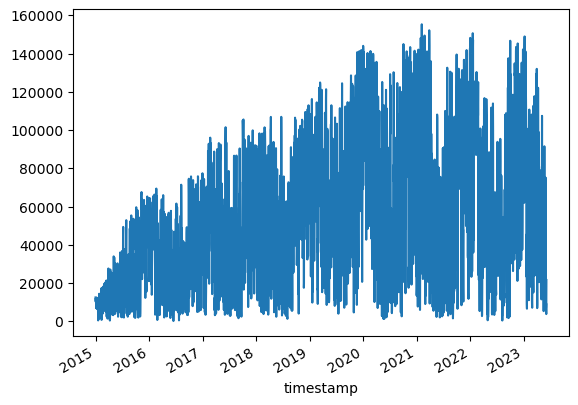

In [11]:
try:
    region = 'DE'
    resolution = 'day'
    # Date from 1.1.2015 to 1.1.2023 in milliseconds
    timestamps = ['1420066800000','1451602800000','1483225200000','1514761200000','1546297200000', '1577833200000', '1609455600000', '1640991600000', '1672527600000']
    filterlist = ['1223', '1224', '1225', '1226', '1227', '1228', '4066', '4067', '4068', '4069', '4070', '4071', '410', '4359', '4387']
    namelist = ['Braunkohle', 'Kernenergie', 'wind offshore', 'Wasserkraft', 'Sonstige Konventionelle', 'Sonstige Erneuerbare', 'Biomasse', 'Wind Onshore', 'Photovoltaik', 'Steinkohle', 'Pumpspeicher', 'Erdgas', 'Gesamt (Netzlast)', 'Residuallast', 'Stromerzeugung']
    addinfo('SMARD DE parameters defined')
except:
    adderror('Error while defining SMARD DE parameters ' + traceback.format_exc())
      

try:
    # creating main dataframe
    de_complete = pd.DataFrame()
    de_complete.insert(0, 'timestamp', [])
    for name in namelist:
        de_complete.insert(namelist.index(name)+1, name, [])
    addinfo('SMARD DE initial dataframe created')
except:
    adderror('Error while creating initial SMARD DE dataframe ' + traceback.format_exc())
      
try:
    # loop over the timestamps and get the data for each timestamp (as data only gives the data for one year)
    for timestamp in timestamps:
        print("timestamp: " + timestamp)
        df = pd.DataFrame()
        df.insert(0, 'timestamp', [])
        # loop over the filterlist and get the data for each filter
        for filter in filterlist:
            data = get_smard_data(filter,region,resolution, timestamp)
            #print("temporarily created df: " + namelist[filterlist.index(filter) ])
            df2 = pd.DataFrame(data['series'])
            df2.columns = df2.columns = ['timestamp', namelist[filterlist.index(filter)]]
            df = pd.merge(df, df2, on='timestamp', how='outer')
        # append the dataframes for each timestamp
        de_complete = pd.concat([de_complete, df])
    de_complete.head()
    addinfo('SMARD DE data loaded')
except:
    adderror('Error while loading SMARD DE data ' + traceback.format_exc())
      
try:
    # make timestamp column to datetime for better readability
    de_complete['timestamp'] = pd.to_datetime(de_complete['timestamp'], unit='ms')
    de_complete = de_complete.set_index('timestamp')
    de_complete['wind offshore'].plot()
    #de_complete.to_csv('../Data/smard_de_generation_data_2015_2023.csv')
    addinfo('SMARD DE data edited and saved to local file')
except:
    adderror('Error while editing SMARD DE data ' + traceback.format_exc())
      

### 2.3 Austria: electricity generation data from smard

#### 2.3.1 query data 

LOG|INFO|2023-06-11 19:08:52|SMARD AT parameters defined
LOG|INFO|2023-06-11 19:08:52|SMARD AT initial dataframe created
timestamp: 1420066800000
timestamp: 1451602800000
timestamp: 1483225200000
timestamp: 1514761200000
timestamp: 1546297200000
timestamp: 1577833200000
timestamp: 1609455600000
timestamp: 1640991600000
timestamp: 1672527600000
LOG|INFO|2023-06-11 19:09:02|SMARD AT data loaded
LOG|INFO|2023-06-11 19:09:02|SMARD AT data edited and saved to local file


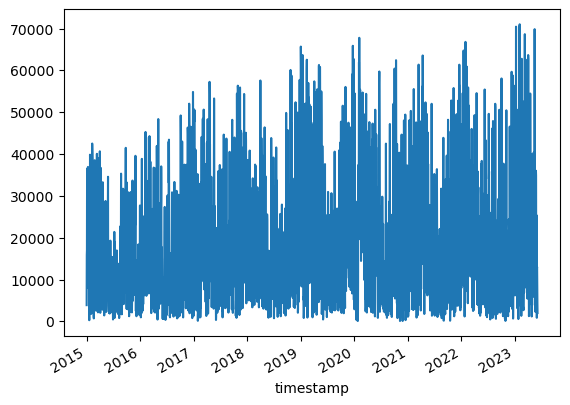

In [12]:
try:
    region = 'AT'
    resolution = 'day'
    # Date from 1.1.2015 to 1.1.2023 in milliseconds
    timestamps = ['1420066800000','1451602800000','1483225200000','1514761200000','1546297200000', '1577833200000', '1609455600000', '1640991600000', '1672527600000']
    filterlist = ['4066','1226','4067','4068', '1228', '4069','4071','4070','1227']
    namelist = ['Biomasse','Wasserkraft','Wind Onshore','Photovoltaik','Sonstige Erneuerbare','Steinkohle','Erdgas','Pumpspeicher','Sonstige Konventionelle']
    addinfo('SMARD AT parameters defined')
except:
    adderror('Error while defining SMARD AT parameters ' + traceback.format_exc())
 

try:
    # creating main dataframe
    at_complete = pd.DataFrame()
    at_complete.insert(0, 'timestamp', [])
    for name in namelist:
        at_complete.insert(namelist.index(name)+1, name, [])
    addinfo('SMARD AT initial dataframe created')
except:
    adderror('Error while creating initial SMARD AT dataframe ' + traceback.format_exc())
   

try:    
    # loop over the timestamps and get the data for each timestamp (as data only gives the data for one year)
    for timestamp in timestamps:
        print("timestamp: " + timestamp)
        df = pd.DataFrame()
        df.insert(0, 'timestamp', [])
        # loop over the filterlist and get the data for each filter
        for filter in filterlist:
            data = get_smard_data(filter,region,resolution, timestamp)
            #print("temporarily created df: " + namelist[filterlist.index(filter)])
            df2 = pd.DataFrame(data['series'])
            df2.columns = df2.columns = ['timestamp', namelist[filterlist.index(filter)]]
            df = pd.merge(df, df2, on='timestamp', how='outer')
        # append the dataframes for each timestamp
        at_complete = pd.concat([at_complete, df]) 
    at_complete.head()
    addinfo('SMARD AT data loaded')
except:
    adderror('Error while loading SMARD AT data ' + traceback.format_exc())


try:
    # make timestamp column to datetime for better readability
    at_complete['timestamp'] = pd.to_datetime(at_complete['timestamp'], unit='ms')
    at_complete = at_complete.set_index('timestamp')
    at_complete['Wind Onshore'].plot()
    #at_complete.to_csv('../Data/smard_at_generation_data_2015_2023.csv')
    addinfo('SMARD AT data edited and saved to local file')
except:
    adderror('Error while editing SMARD AT data ' + traceback.format_exc())


#### 2.3.2 add corresponding CO2 intensity for Germany and Austria
- corresponding energy types in co2_intensity table
    - use same category for 'Braunkohle' and 'Steinkohle' as 'coal'
    - Sonstige Erneuerbare': include Erdwärme, Deponiegas, Klärgas, Grubengas
    - Sonstige Konventionelle: 
        - Abgeleitetes Gas aus Kohle, Mineralöl, Abfall, Gichtgas, Hochofengas, Raffineriegas, 
        - Gas mit hohem Wasserstoffanteil, sonstige Reststoffe aus der Produktion (z.B. Stahl- und Kokserzeugung),
        - Gemische aus mehreren Brennstoffen
    - 'Photovoltaik': 'solarPV polySi ground-mounted'
        - Because Fraunhofer reported the most commenly used type of solar panel in Germany is ground mounted poly-Si solar panels 
    - 'Pumpspeicher': 'hydro'. It is same as HYDRO_WATER_RESERVOIR in rte data.
        - Here I will convert the value to negatvie, as in rte data. 
    - 'Sonstige Konventionelle': not found co2 emission, temporarily use the mean of coal, gas, oil and waste (mean = 645)
        - Derived gas from coal, mineral oil, Waste, blast furnace gas, blast furnace gas, refinery gas, Gas with high hydrogen content, other residues from production (e.g. steel and coke production), Mixtures of several fuels
        - They are conventional power plants that are not classified as hard coal, lignite, natural gas, or oil
    - 'Sonstige Erneuerbare': use methane gas (400), because 3 types in this category are methane gas, though geothermal has low emission
        - Geothermal energy (38), landfill gas, sewage gas, mine gas (the three gas types primarily composed of methane (CH4) )
        - renewable energy sources in Germany that are not classified as wind, solar, hydropower, or bioenergy. 

In [13]:
try:
    smard_de = de_complete.copy().dropna(how='all').reset_index().drop(['Gesamt (Netzlast)','Residuallast',	'Stromerzeugung'], axis=1)
    smard_at = at_complete.copy().dropna(how='all').reset_index()
    # convert Pumpspeicher to negative values
    smard_de['Pumpspeicher'] = smard_de['Pumpspeicher']* (-1)
    smard_de = pd.melt(smard_de, id_vars='timestamp', var_name='production_type', value_name='value').dropna(subset=['value'])
    smard_at['Pumpspeicher'] = smard_at['Pumpspeicher']* (-1)
    smard_at = pd.melt(smard_at, id_vars='timestamp', var_name='production_type', value_name='value').dropna(subset=['value'])
    addinfo('SMARD data prepared for further processing')
except:
    adderror('Error while preparing SMARD data ' + traceback.format_exc())
 

try:
    # change the timestamp to the form of year-month-day, as there is only one time point per day
    smard_de['timestamp'] = pd.to_datetime(smard_de['timestamp'])
    smard_de['date'] = smard_de['timestamp'].dt.strftime('%Y-%m-%d')
    smard_de.drop('timestamp', axis=1, inplace=True)
    smard_at['timestamp'] = pd.to_datetime(smard_at['timestamp'])
    smard_at['date'] = smard_at['timestamp'].dt.strftime('%Y-%m-%d')
    smard_at.drop('timestamp', axis=1, inplace=True)
    smard_de
    addinfo('SMARD data ready for co2 mapping')
except:
    adderror('Error while preparing SMARD data for co2 mapping ' + traceback.format_exc())


LOG|INFO|2023-06-11 19:09:03|SMARD data prepared for further processing
LOG|INFO|2023-06-11 19:09:03|SMARD data ready for co2 mapping


In [14]:
try:
    # add co2 emission: gCO2eq/kWh column        
    production_type = smard_de.production_type.unique()
    source_de = ['de coal', 'de nuclear', 'wind offshore', 'de hydro','other conventional','other renewables','biomass','wind onshore',
            'solarPV polySi ground-mounted','coal','de hydro','natural gas']
    source_at = ['coal', 'nuclear', 'wind offshore', 'hydro','other conventional','other renewables','biomass','wind onshore',
            'solarPV polySi ground-mounted','coal','hydro','natural gas']
    # new column to map source names
    mapping_dict_de = dict(zip(production_type, source_de))
    smard_de['source'] = smard_de['production_type'].map(mapping_dict_de)
    # add gCO2eq/kWh to indicate co2 emission per unit electricity generation
    smard_de = pd.merge(smard_de, co2_intensity, left_on='source', right_on='technology', how='left').rename(columns={'median': 'gCO2eq/kWh'}).drop('technology',axis=1)

    mapping_dict_at = dict(zip(production_type, source_at))
    smard_at['source'] = smard_at['production_type'].map(mapping_dict_at)
    # add gCO2eq/kWh to indicate co2 emission per unit electricity generation
    smard_at = pd.merge(smard_at, co2_intensity, left_on='source', right_on='technology', how='left').rename(columns={'median': 'gCO2eq/kWh'}).drop('technology',axis=1)
    # calculate total co2 emission for each row
    smard_de['total_gCO2eq'] = smard_de['value']*1000*smard_de['gCO2eq/kWh']
    smard_at['total_gCO2eq'] = smard_at['value']*1000*smard_at['gCO2eq/kWh']
    smard_de
    addinfo('SMARD data enriched with CO2 intensity')
except:
    adderror('Error while mapping co2 data to SMARD data ' + traceback.format_exc())
      

LOG|INFO|2023-06-11 19:09:03|SMARD data enriched with CO2 intensity


#### 2.3.3 calculate the total gCO2eq of each row, and use it to further calculate the CO2 intensity of the electricity mix 

In [15]:
try:
    # sum up co2 emission for each day, and divide by the total electricity generation value to get the average co2 emission per kWh
    smard_de_total = smard_de.groupby(['date']).sum().reset_index().drop(['gCO2eq/kWh'], axis=1) # drop the gCO2eq/kWh of each technology
    smard_de_total['gCO2eq/kWh'] = smard_de_total['total_gCO2eq']/(smard_de_total['value']*1000) # calculate gCO2eq/kWh of the mixed electricity generation

    smard_at_total = smard_at.groupby(['date']).sum().reset_index().drop(['gCO2eq/kWh'], axis=1) # drop the gCO2eq/kWh of each technology
    smard_at_total['gCO2eq/kWh'] = smard_at_total['total_gCO2eq']/(smard_at_total['value']*1000) # calculate gCO2eq/kWh of the mixed electricity generation
    smard_de_total
    addinfo('SMARD data added average CO2 emission per kwH')
except:
    adderror('Error while adding average CO2 emission per kwH to SMARD data ' + traceback.format_exc())
      

LOG|INFO|2023-06-11 19:09:03|SMARD data added average CO2 emission per kwH


## 2.4 Italy: electricity generation data from Terna 
### 2.4.1 query data
- Accessing API with Token and generating data in steps of 60 days
- data updated every hour

In [16]:
# Generate the token using the key and secret
try:
    tokenurl = 'https://api.terna.it/transparency/oauth/accessToken'
    # Key and Secret for the API, generated by creating an account and application on the website and stored in the .env file
    tokendata = {
        'client_id': terna_client_id,
        'client_secret': terna_client_secret,
        'grant_type': 'client_credentials'
    }

    tokenheaders = {'Content-Type': 'application/x-www-form-urlencoded'}
    response = requests.post(tokenurl, data=tokendata, headers=tokenheaders)
    access_token = json.loads(response.content.decode('utf-8'))['access_token']
    addinfo('Token received')
except:
    adderror('Error while getting token from Terna ' + traceback.format_exc())
    

LOG|INFO|2023-06-11 19:09:08|Token received


In [17]:
if response.status_code == 200:
        try:
            # loop for the dates so that it makes 60 day steps until today
            datelist = pd.date_range(start="2018-01-01", end=datetime.now().strftime("%Y-%m-%d"), freq='60D').tolist()
            datelist = [datetime.strftime(date, "%d/%m/%Y") for date in datelist]
            # sleeps are entered because the API only allows 1 request per second
            time.sleep(1)
            df_italy = pd.DataFrame()

            for i in range(len(datelist)-1):
                params = {
                    "dateFrom": datelist[i],
                    "dateTo": datelist[i+1]
                }
                headers = {'Authorization': f'Bearer {access_token}'}
                response = requests.get(url, headers=headers, params=params)
                print(response.status_code)
                data = response.json()
                df_italytemp = pd.DataFrame(data['actualGeneration'])
                df_italy = pd.concat([df_italy, df_italytemp])
                # sleep because of QPS limit
                time.sleep(1)
            print(df_italy.head())
        except:
            adderror('Error while loading Terna data ' + traceback.format_exc())
            
else:
    adderror('Failed to generate token' + str(response.text))

401
LOG|ERROR|2023-06-11 19:09:09|Error while loading Terna data Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/requests/models.py", line 971, in json
    return complexjson.loads(self.text, **kwargs)
  File "/opt/anaconda3/lib/python3.9/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/opt/anaconda3/lib/python3.9/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/opt/anaconda3/lib/python3.9/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/var/folders/4r/tcytcqc56n3bcqfhnmthgtf80000gn/T/ipykernel_26901/2323147510.py", line 18, in <cell line: 1>
    data = response.json()
  File "/opt/anaconda3/lib/python3.9/site-packages

### 2.4.2 add corresponding CO2 intensity 

- corresponding energy types in co2_intensity table
    - thermal: use natural gas (490) in co2_intensity table. Because thermal power plants in Italy utilize a combination of **natural gas, coal, and oil** to produce electricity. **Natural gas-fired** power plants are the **most prevalent** and have been favored due to their relatively lower carbon emissions compared to coal and oil.
    - Hydro: 24 gCO2/kWh, hydrop as in co2_intensity table
    - Geothermal: 38 gCO2/kWh
    - Photovoltaic: solar photovoltaic or solar PV. In Italy, both utility-scale (48) and rooftop solar PV (41) systems are commonly used. So let's use the average of the two --> 44.5 gCO2/kWh
    - Wind: primary focus for wind energy generation is onshore wind farms. So we will take wind onshore in co2_intensity table

In [18]:
try:
    # terna_it = df_italy.copy()
    terna_it = pd.read_csv('../Data/italy_actual_generation.csv')
    # change the timestamp to the form of year-month-day
    terna_it['Date'] = pd.to_datetime(terna_it['Date'])
    terna_it['Actual_Generation_GWh'] = terna_it['Actual_Generation_GWh'].astype(float)
    # sum up the generation quantity by Date&Primary_Source
    terna_it = terna_it.groupby(['Date','Primary_Source']).sum().reset_index()
    # convert the generation unit from GWh to MWh as the data of other three countries
    terna_it['Actual_Generation_MWh'] = terna_it['Actual_Generation_GWh'] * 1000
    # drop the Actual_Generation_GWh column
    terna_it = terna_it.drop('Actual_Generation_GWh', axis=1)
    # drop the 'Self-consumption' from Primary_Source attribute, because it is not a generation source type
    terna_it = terna_it[terna_it['Primary_Source']!='Self-consumption']
    terna_it
    addinfo('Terna data prepared for further processing')
except:
    adderror('Error while preparing Terna data for further processing' + traceback.format_exc())


LOG|INFO|2023-06-11 19:09:10|Terna data prepared for further processing


In [19]:
try:
    # add co2 emission: gCO2eq/kWh column        
    production_type = ['Thermal', 'Hydro', 'Geothermal', 'Photovoltaic', 'Wind']
    source = ['natural gas','hydro','geothermal','solarPV rooftop&utilityscale','wind onshore']
    co2_intensity_it = [490,24,38,44.5,12]
    # map co2 intensity to the corresponding source
    mapping_dict_it = dict(zip(production_type, co2_intensity_it))
    # map new source names
    mapping_dict_it2 = dict(zip(production_type, source))
    terna_it['gCO2eq/kWh'] = terna_it['Primary_Source'].map(mapping_dict_it)
    terna_it['source'] = terna_it['Primary_Source'].map(mapping_dict_it2)
    terna_it = terna_it.drop('Primary_Source',axis=1)
    terna_it
    addinfo('Terna data enriched with CO2 intensity')
except:
    adderror('Error while mapping co2 data to Terna data ' + traceback.format_exc())


LOG|INFO|2023-06-11 19:09:10|Terna data enriched with CO2 intensity


### 2.4.3 calculate the total gCO2eq of each row, and use it to further calculate the CO2 intensity of the electricity mix 

In [20]:
try:   
    # italy total generation per day
    it_total = terna_it.copy()
    # calculate total co2 emission for each row
    it_total['total_gCO2eq'] = it_total['Actual_Generation_MWh']*1000*it_total['gCO2eq/kWh']
    # convert date to y-m-d
    it_total['Date'] = it_total['Date'].dt.strftime('%Y-%m-%d')
    it_total = it_total.groupby('Date').sum().reset_index().drop(['source','gCO2eq/kWh'],axis=1)
    it_total['gCO2eq/kWh'] = it_total['total_gCO2eq']/(it_total['Actual_Generation_MWh']*1000)
    it_total['country'] = 'Italy'
    it_total
    addinfo('Terna data added average CO2 emission per kwH')
except:
    adderror('Error while adding average CO2 emission per kwH to Terna data ' + traceback.format_exc())

LOG|INFO|2023-06-11 19:09:10|Terna data added average CO2 emission per kwH


### 2.5 Concat all four countries data in one df

#### 2.5.1 concat the generation mix data of four countries

In [21]:
try:
    # DE & AT
    de_total = smard_de_total.copy().iloc[1:,:] # start from 2015-01-01
    de_total = de_total.drop(['production_type','source'],axis=1)
    de_total['country'] = 'Germany'
    at_total = smard_at_total.copy().iloc[1:,:] # start from 2015-01-01
    at_total = at_total.drop(['production_type','source'],axis=1)
    at_total['country'] = 'Austria'
    addinfo('DE & AT Data prepared to be concatenated')
except:
    adderror('Error while preparing DE & AT data to be concatenated ' + traceback.format_exc())
    #exit()
# FR
try:
    fr_total = rte_fr_total.drop('production_type',axis=1)
    fr_total['date'] = fr_total['start_date'].str[:10]
    fr_total.drop(['start_date','end_date','source'], axis=1, inplace=True)
    fr_total = fr_total.groupby(['date']).sum()
    fr_total['gCO2eq/kWh'] = fr_total['gco2eq']/(fr_total['value']*1000)
    fr_total['country'] = 'France'
    fr_total.reset_index(inplace=True)
    fr_total.columns = ['date', 'value', 'gCO2eq/kWh', 'total_gCO2eq','country']
    addinfo('FR Data prepared to be concatenated')
except:
    adderror('Error while preparing FR data to be concatenated ' + traceback.format_exc())
    #exit()
# IT
try:
    it_total.columns = ['date',	'value','total_gCO2eq',	'gCO2eq/kWh','country']
    addinfo('IT Data prepared to be concatenated')
except:
    adderror('Error while preparing IT data to be concatenated ' + traceback.format_exc())
    #exit()
try:
    # concatenate the dataframes
    de_at_fr_it_total_generation_data_2015_2023 = pd.concat([de_total, at_total, fr_total,it_total], axis=0)
    de_at_fr_it_total_generation_data_2015_2023.columns = ['date', 'total_generation(MWh)', 'total_gCO2eq', 'gCO2eq/kWh', 'country']
    de_at_fr_it_total_generation_data_2015_2023.to_csv('../Data/de_at_fr_it_total_generation_data_2015_2023.csv')
    de_at_fr_it_total_generation_data_2015_2023
    addinfo('Data concatenated and saved to local file')
except:
    adderror('Error while concatenating data ' + traceback.format_exc())
    #exit()

LOG|INFO|2023-06-11 19:09:10|DE & AT Data prepared to be concatenated
LOG|INFO|2023-06-11 19:09:10|FR Data prepared to be concatenated
LOG|INFO|2023-06-11 19:09:10|IT Data prepared to be concatenated
LOG|INFO|2023-06-11 19:09:10|Data concatenated and saved to local file


#### 2.5.2 concat the generation per source data

In [22]:
try:
    fr_type = rte_2015_2023_types.copy()
    fr_type['date'] = fr_type['start_date'].str[:10]
    fr_type.drop(['start_date','end_date','production_type','gCO2eq/kWh'], axis=1, inplace=True)
    fr_type = fr_type.groupby(['date','source']).sum().reset_index()
    # add gCO2eq/kWh (by production type) to indicate co2 emission per unit electricity generation
    fr_type = pd.merge(fr_type, co2_intensity, left_on='source', right_on='technology', how='left').rename(columns={'median': 'gCO2eq/kWh'}).drop('technology',axis=1)
    fr_type.columns = ['date', 'source', 'value', 'total_gCO2eq', 'gCO2eq/kWh']
    fr_type = pd.merge(fr_type, fr_total, how='left', on='date')
    fr_type['proportion_electr_generation'] = fr_type['value_x']/fr_type['value_y']*100
    fr_type = fr_type[['date', 'source', 'value_x', 'proportion_electr_generation', 'gCO2eq/kWh_x', 'total_gCO2eq_x', 'country']]
    fr_type.columns = ['date', 'source', 'value', 'proportion_electr_generation', 'gCO2eq/kWh', 'total_gCO2eq', 'country']
    fr_type
    addinfo('FR Data enriched with proportion of electricity generation')
except:
    adderror('Error while enriching FR data with proportion of electricity generation ' + traceback.format_exc())
      

LOG|INFO|2023-06-11 19:09:10|FR Data enriched with proportion of electricity generation


In [23]:
try:
    # DE
    de_type = smard_de.copy()
    de_type.drop(['production_type'], axis=1, inplace=True)
    de_type = pd.merge(de_type, de_total, how='left', on='date')
    de_type['proportion_electr_generation'] = de_type['value_x']/de_type['value_y']*100
    de_type = de_type[['date', 'source', 'value_x', 'proportion_electr_generation', 'gCO2eq/kWh_x', 'total_gCO2eq_x', 'country']]
    de_type.columns = ['date', 'source', 'value', 'proportion_electr_generation', 'gCO2eq/kWh', 'total_gCO2eq', 'country']
    de_type = de_type.dropna(subset = ['proportion_electr_generation'])
    addinfo('DE Data enriched with proportion of electricity generation')
except:
    adderror('Error while enriching DE data with proportion of electricity generation ' + traceback.format_exc())
      
try:
    # AT
    at_type = smard_at.copy()
    at_type.drop(['production_type'], axis=1, inplace=True)
    at_type = pd.merge(at_type, at_total, how='left', on='date')
    at_type['proportion_electr_generation'] = at_type['value_x']/at_type['value_y']*100
    at_type = at_type[['date', 'source', 'value_x', 'proportion_electr_generation', 'gCO2eq/kWh_x', 'total_gCO2eq_x', 'country']]
    at_type.columns = ['date', 'source', 'value', 'proportion_electr_generation', 'gCO2eq/kWh', 'total_gCO2eq', 'country']
    at_type = at_type.dropna(subset = ['proportion_electr_generation'])
    at_type
    addinfo('AT Data enriched with proportion of electricity generation')
except:
    adderror('Error while enriching AT data with proportion of electricity generation ' + traceback.format_exc())
      

LOG|INFO|2023-06-11 19:09:10|DE Data enriched with proportion of electricity generation
LOG|INFO|2023-06-11 19:09:10|AT Data enriched with proportion of electricity generation


In [24]:
try:
    # IT
    it_type = terna_it.copy()
    it_type['date'] = it_type['Date'].dt.strftime('%Y-%m-%d')
    it_type = it_type.drop('Date',axis=1)
    it_type = it_type.groupby(['date','source','gCO2eq/kWh']).sum().reset_index()
    it_type['total_gCO2eq'] = it_type['gCO2eq/kWh']*it_type['Actual_Generation_MWh']*1000
    it_type['country'] = 'Italy'
    it_type = pd.merge(it_type, it_total[['date','value']], how='left', on='date')
    it_type['proportion_electr_generation'] = it_type['Actual_Generation_MWh']/it_type['value']*100
    it_type = it_type.drop('value',axis=1)
    it_type.columns = ['date', 'source', 'gCO2eq/kWh', 'value', 'total_gCO2eq','country','proportion_electr_generation']
    it_type
    addinfo('IT Data enriched with proportion of electricity generation')
except:
    adderror('Error while enriching IT data with proportion of electricity generation ' + traceback.format_exc())
      

LOG|INFO|2023-06-11 19:09:10|IT Data enriched with proportion of electricity generation


In [25]:
try:
    de_at_fr_it_type_generation_data_2015_2023 = pd.concat([de_type, at_type, fr_type,it_type], axis=0)
    de_at_fr_it_type_generation_data_2015_2023.columns = ['date', 'source', 'total_generation(MWh)', 'proportion_electr_generation', 'gCO2eq/kWh', 'total_gCO2eq', 'country']
    de_at_fr_it_type_generation_data_2015_2023.to_csv('../Data/de_at_fr_it_type_generation_data_2015_2023.csv')
    de_at_fr_it_type_generation_data_2015_2023
    addinfo('Data concatenated and saved to local file')
except:
    adderror('Error while concatenating data ' + traceback.format_exc())
      

LOG|INFO|2023-06-11 19:09:11|Data concatenated and saved to local file


## 3 import export electricity data of Switzerland

In [26]:
try:
    url = 'https://www.uvek-gis.admin.ch/BFE/ogd/35/ogd35_schweizerische_elektrizitaetsbilanz_monatswerte.csv'
    r = requests.get(url, allow_redirects=True)
    open('../Data/ogd35_schweizerische_elektrizitaetsbilanz_monatswerte.csv', 'wb').write(r.content)
    df_electricity_data_ch = pd.read_csv('../Data/ogd35_schweizerische_elektrizitaetsbilanz_monatswerte.csv', header=0, index_col=0, parse_dates=True, sep=',')

    #df_electricity_data_ch = pd.read_csv('../Data/ogd35_schweizerische_elektrizitaetsbilanz_monatswerte.csv', header=0, index_col=0, parse_dates=True, squeeze=True, sep=',')
    addinfo('Electricity data for Switzerland loaded')
except:
    adderror('Error while loading electricity data for Switzerland ' + traceback.format_exc())
    #exit()

LOG|INFO|2023-06-11 19:09:11|Electricity data for Switzerland loaded


In [27]:
try:
    df_electricity_data_ch.reset_index(inplace=True)
    df_electricity_data_ch['Jahr'] = df_electricity_data_ch['Jahr'].astype(str).str[:4] + df_electricity_data_ch['Monat'].astype(str).str.zfill(2) + '01'
    # convert the column Jahr to a datetime object
    df_electricity_data_ch['Jahr'] = pd.to_datetime(df_electricity_data_ch['Jahr'], format='%Y%m%d')
    df_electricity_data_ch.set_index('Jahr', inplace=True)
    df_electricity_data_ch.drop('Monat', axis=1, inplace=True)

    df_electricity_data_ch_export = df_electricity_data_ch.copy()
    df_electricity_data_ch_export.reset_index(inplace=True)
    df_electricity_data_ch_export.to_csv('../Data/df_electricity_data_ch_edited.csv')
    df_electricity_data_ch.head()
    addinfo('Electricity data for Switzerland edited')
except:
    adderror('Error while editing electricity data for Switzerland ' + traceback.format_exc())
    #exit()

LOG|INFO|2023-06-11 19:09:11|Electricity data for Switzerland edited


In [28]:
try:
    url = 'https://pubdb.bfe.admin.ch/de/publication/download/9333'
    r = requests.get(url, allow_redirects=True)
    open('../Data/aussenhandel_schweiz.xlsx', 'wb').write(r.content)
    addinfo('Trade data for Switzerland loaded')
except:
    adderror('Error while loading trade data for Switzerland ' + traceback.format_exc())
    #exit()

try:
    file_path = '../Data/aussenhandel_schweiz.xlsx'
    workbook = load_workbook(file_path)
    sheet = workbook.worksheets[0]
    rows_to_delete = [1, 2, 3, 4, 5, 6, 7,9] 

    for row in reversed(rows_to_delete):  # Delete rows in reverse order to avoid index shifting
        sheet.delete_rows(row)

    # Delete columns
    columns_to_delete = ['AM', 'AL', 'AK', 'AJ', 'AI', 'AH', 'AG', 'AF', 'AE', 'AD', 'AC', 'AB', 'AA', 'Z', 'Y', 'X', 'W', 'V', 'U', 'T', 'S', 'R', 'Q', 'P', 'O', 'N', 'M', 'L', 'K', 'J', 'I', 'H', 'G']

    for col in columns_to_delete:
        col_index = column_index_from_string(col)  # Convert column letter to integer index
        sheet.delete_cols(col_index, 1)

    workbook.save('../Data/import.xlsx')
    addinfo('Trade import data for Switzerland edited')
except:
    adderror('Error while editing trade import data for Switzerland ' + traceback.format_exc())
    #exit()

LOG|INFO|2023-06-11 19:09:11|Trade data for Switzerland loaded
LOG|INFO|2023-06-11 19:09:12|Trade import data for Switzerland edited


In [29]:
try:
    workbook = load_workbook(file_path)
    sheet = workbook.worksheets[0]
    rows_to_delete = [1, 2, 3, 4, 5, 6, 7, 9] 

    for row in reversed(rows_to_delete):  # Delete rows in reverse order to avoid index shifting
        sheet.delete_rows(row)

    # Delete columns
    columns_to_delete = ['AM', 'AL', 'AK', 'AJ', 'AI', 'AH', 'AG', 'AF', 'AE', 'AD', 'AC', 'AB', 'AA', 'Z', 'Y', 'X', 'W', 'V', 'U', 'T', 'S', 'R', 'Q', 'P', 'O', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A']

    for col in columns_to_delete:
        col_index = column_index_from_string(col)  # Convert column letter to integer index
        sheet.delete_cols(col_index, 1)

    workbook.save('../Data/export.xlsx')
    addinfo('Trade export data for Switzerland edited')
except:
    adderror('Error while editing trade export data for Switzerland ' + traceback.format_exc())
    #exit()
try:
    # load import export data
    df_import = pd.read_excel('../Data/import.xlsx')
    df_export = pd.read_excel('../Data/export.xlsx')

    #rename the first columns of the dataframes to 'Datum'
    df_import.rename(columns={'Unnamed: 0': 'Datum'}, inplace=True)
    df_export.rename(columns={'Unnamed: 0': 'Datum'}, inplace=True)

    #left join the two dataframes
    df_import_export = df_import.merge(df_export, on='Datum', how='left', suffixes=('_import', '_export'))
    addinfo('Trade data for Switzerland merged')
except:
    adderror('Error while merging trade data for Switzerland ' + traceback.format_exc())
    #exit()



LOG|INFO|2023-06-11 19:09:12|Trade export data for Switzerland edited
LOG|INFO|2023-06-11 19:09:12|Trade data for Switzerland merged


In [30]:
try:
    import locale
    locale.setlocale(locale.LC_TIME, 'de_DE')
    date_format = '%B %Y'
    df_import_export['Datum'] = pd.to_datetime(df_import_export['Datum'], format=date_format)
    df_import_export = df_import_export.set_index('Datum')
    # change Datumsformat to YYYY-MM-DD
    df_import_export.index = df_import_export.index.strftime('%Y-%m-%d')
    df_import_export_export = df_import_export.copy()
    df_import_export_export.reset_index(inplace=True)
    df_import_export_export.to_csv('../Data/df_import_export_edited.csv')
    addinfo('Trade data for Switzerland edited')
except:
    adderror('Error while editing trade data for Switzerland ' + traceback.format_exc())
    #exit()


LOG|INFO|2023-06-11 19:09:12|Trade data for Switzerland edited


<AxesSubplot:xlabel='Datum'>

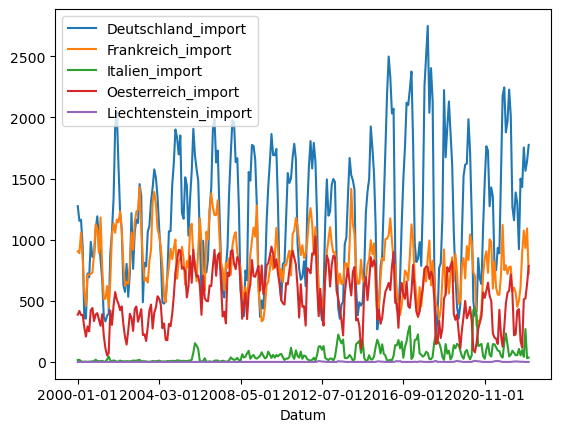

In [31]:

df_import_export[['Deutschland_import','Frankreich_import','Italien_import','Oesterreich_import','Liechtenstein_import']].plot()

In [32]:
# convert to long table and save locally
import_export = pd.read_csv('../Data/df_import_export_edited.csv', sep=',').iloc[:,1:7]
import_export.columns = ['Date','Germany','France','Italy','Austria','Liechtenstein']
import_export_long = pd.melt(import_export, id_vars=['Date'], var_name='country', value_name='import_quantity(MWh)')
import_export_long.to_csv('../Data/import_export_long.csv')
import_export_long

,Date,country,import_quantity(MWh)
0,2000-01-01,Germany,1274
1,2000-02-01,Germany,1154
2,2000-03-01,Germany,1162
3,2000-04-01,Germany,947
4,2000-05-01,Germany,358
...,...,...,...
1385,2022-10-01,Liechtenstein,2
1386,2022-11-01,Liechtenstein,0
1387,2022-12-01,Liechtenstein,0
1388,2023-01-01,Liechtenstein,0


## 4 market electricity price from smard
### 4.1 load market price data of DE, CH, AT, IT, FR

In [33]:
try:
    region = 'DE'
    resolution = 'day'
    # Attention, different timestamps than before, because the data is not available for the whole time period
    timestamps = ['1514761200000','1546297200000','1577833200000','1609455600000','1640991600000', '1672527600000']
    filterlist = ['4169','259','4170','255','254']
    namelist = ['Marktpreis_deutschland', 'Marktpreis_Schweiz', 'Marktpreis_Österreich', 'Marktpreis_Italien_Nord','Marktpreis_Frankreich']

    df_complete_price = pd.DataFrame()
    df_complete_price.insert(0, 'timestamp', [])
    for name in namelist:
        df_complete_price.insert(namelist.index(name)+1, name, [])
    addinfo('SMARD DE Marketdata parameters defined')
except:
    adderror('Error while defining SMARD DE Marketdata parameters ' + traceback.format_exc())
    #exit()

try:
    # loop over the timestamps and get the data for each timestamp
    for timestamp in timestamps:
        print("timestamp: " + timestamp)
        df = pd.DataFrame()
        df.insert(0, 'timestamp', [])
        # loop over the filterlist and get the data for each filter
        for filter in filterlist:
            data = get_smard_data(filter,region,resolution, timestamp)
            print("temporarily created df: " + namelist[filterlist.index(filter)])
            df2 = pd.DataFrame(data['series'])
            df2.columns = df2.columns = ['timestamp', namelist[filterlist.index(filter)]]
            df = pd.merge(df, df2, on='timestamp', how='outer')
        df_complete_price = pd.concat([df_complete_price, df], ignore_index=True)
    df_complete_price.head()
    df_complete_price.to_csv('../Data/df_complete_price_raw.csv', index=False)
    addinfo('SMARD DE Marketdata loaded')
except:
    adderror('Error while loading SMARD DE Marketdata ' + traceback.format_exc())

LOG|INFO|2023-06-11 19:09:12|SMARD DE Marketdata parameters defined
timestamp: 1514761200000
temporarily created df: Marktpreis_deutschland
temporarily created df: Marktpreis_Schweiz
temporarily created df: Marktpreis_Österreich
temporarily created df: Marktpreis_Italien_Nord
temporarily created df: Marktpreis_Frankreich
timestamp: 1546297200000
temporarily created df: Marktpreis_deutschland
temporarily created df: Marktpreis_Schweiz
temporarily created df: Marktpreis_Österreich
temporarily created df: Marktpreis_Italien_Nord
temporarily created df: Marktpreis_Frankreich
timestamp: 1577833200000
temporarily created df: Marktpreis_deutschland
temporarily created df: Marktpreis_Schweiz
temporarily created df: Marktpreis_Österreich
temporarily created df: Marktpreis_Italien_Nord
temporarily created df: Marktpreis_Frankreich
timestamp: 1609455600000
temporarily created df: Marktpreis_deutschland
temporarily created df: Marktpreis_Schweiz
temporarily created df: Marktpreis_Österreich
tempor

LOG|INFO|2023-06-11 19:09:16|SMARD DE Marketdata edited and saved to local file


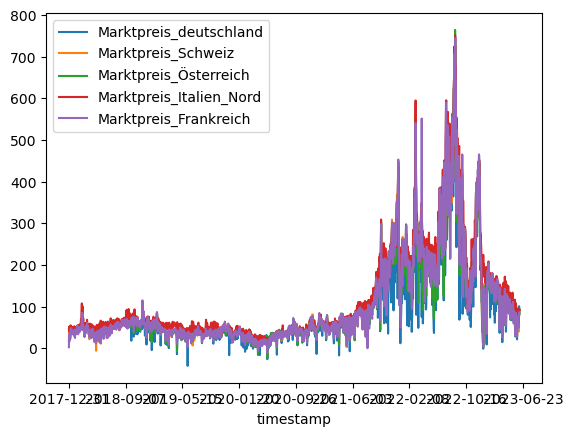

In [34]:
try:
    # make timestamp column to datetime, and keep it to the form of 2017-12-31
    df_complete_price['timestamp'] = pd.to_datetime(df_complete_price['timestamp'], unit='ms')
    #df_complete_price['timestamp'] = pd.to_datetime(df_complete_price['timestamp'])
    df_complete_price['timestamp'] = df_complete_price['timestamp'].dt.strftime('%Y-%m-%d')
    df_complete_price.to_csv('../Data/market_price_data_five_countries.csv', index=False)
    df_complete_price = df_complete_price.set_index('timestamp')
    df_complete_price.plot()
    addinfo('SMARD DE Marketdata edited and saved to local file')
except:
    adderror('Error while editing SMARD DE Marketdata ' + traceback.format_exc())

In [35]:
try:
    # convert to long table and save locally
    df_complete_price_long = pd.read_csv('../Data/market_price_data_five_countries.csv')
    df_complete_price_long.columns = ['date','Germany','Switzerland','Austria','Italy','France']
    df_complete_price_long = pd.melt(df_complete_price_long, id_vars=['date'], var_name='country', value_name='market_price(€/MWh))')
    df_complete_price_long
    addinfo('SMARD DE Marketdata converted to long table')
except:
    adderror('Error while converting SMARD DE Marketdata to long table ' + traceback.format_exc())
    #exit()

LOG|INFO|2023-06-11 19:09:16|SMARD DE Marketdata converted to long table


### 4.2 join the co2 emission intensity of the electricity mix per country per day

In [36]:
try:
    de_at_fr_it_total_generation_data_2015_2023 = pd.read_csv('../Data/de_at_fr_it_total_generation_data_2015_2023.csv').iloc[:,1:]
    co2_intensity_country_day = de_at_fr_it_total_generation_data_2015_2023[['date','gCO2eq/kWh','country']]
    df_complete_price_long = df_complete_price_long.merge(co2_intensity_country_day, on=['date','country'], how='left').dropna(how='any')
    df_complete_price_long.to_csv('../Data/market_price_data_five_countries_long.csv', index=False)
    df_complete_price_long
    addinfo('SMARD DE Marketdata enriched with CO2 intensity')
except:
    adderror('Error while enriching SMARD DE Marketdata with CO2 intensity ' + traceback.format_exc())
    #exit()

LOG|INFO|2023-06-11 19:09:16|SMARD DE Marketdata enriched with CO2 intensity


### 4.3 set co2 baseline based on Switzerland long-term climate goal

##### According to the Switzerland long-term climate strategy to 2050, 
- Goal 1: Switzerland has committed to reducing greenhouse gas emissions by 50% relative to 1990 levels by 2030, including international credits. 
- Goal 2: The long-term climate strategy shows that Switzerland can reduce its greenhouse gas emissions by 2050 to around 90 per cent of the 1990 level. The remaining emissions must be balanced with negative emissions technologies (see: CO2 capture, removal and storage).  
##### we will establish a CO2 baseline that reflects the gradual reduction in CO2 intensity over time. This baseline will serve as a reference for evaluating and monitoring progress towards achieving the desired goals of CO2 emissions reduction.

#### 4.3.1 start point of CO2 intensity by electricity generation in Switzerland in 1990

Due to difficulty of searching the CO2 intensity by electricity generation of Switzerland in 1990 (maybe not free data), we will use the average CO2 intensity by electricity generation of the four neighbor countries as a reference.

In [37]:
# average CO2 intensity of electricity generation from DE, FR, IT, AT from 1990 to 2016
try:
    co2_intensity_countries = pd.read_csv('../Data/co2-emission-intensity.csv')
    selected_countries = ['Austria', 'Germany', 'Italy', 'France']
    co2_intensity_4_country = co2_intensity_countries[co2_intensity_countries['Member State:text'].isin(selected_countries)][['Date:year', 'Member State:text',
        'CO2 emission intensity:number']]
    count_countries_per_year = co2_intensity_4_country.groupby('Date:year').count()['Member State:text'].reset_index()
    avg_intensity_per_year = co2_intensity_4_country[['Date:year', 'CO2 emission intensity:number']].groupby('Date:year').mean().reset_index()
    avg_co2_intensity_4_country = pd.merge(count_countries_per_year, avg_intensity_per_year, on = 'Date:year')
    avg_co2_intensity_4_country.columns = ['date','count country', 'mean_co2_intensity(gco2eq/kWh)']
    avg_co2_intensity_4_country.to_csv('../Data/avg_co2_intensity_4_country.csv')
    addinfo('average CO2 intensity of electricity generation from DE, FR, IT, AT from 1990 to 2016 is created')
except:
    avg_co2_intensity_4_country = pd.read_csv('../Data/avg_co2_intensity_4_country.csv')
    adderror('Error while creating average CO2 intensity of electricity generation from DE, FR, IT, AT from 1990 to 2016' + traceback.format_exc())

LOG|INFO|2023-06-11 19:09:16|average CO2 intensity of electricity generation from DE, FR, IT, AT from 1990 to 2016 is created


#### 4.3.2 generate CO2 baseline for Switzerland per day from 1990 to 2050
CO2 intensity is gradually reduced each day to reach the goal 1 (50% reduction at end of 2030 comparing to 1990) and goal 2 (90% reduction at end of 2050 comparing to 1990)

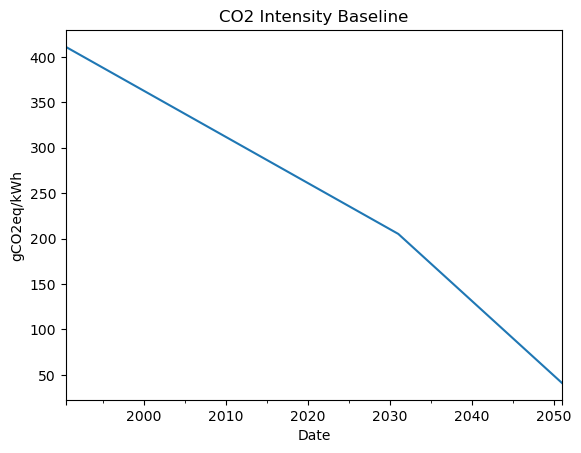

LOG|INFO|2023-06-11 19:09:16|CO2 baseline created


In [38]:
try:
    startvalue = avg_co2_intensity_4_country[avg_co2_intensity_4_country['date'] == 1990]['mean_co2_intensity(gco2eq/kWh)']
    endvalue1 = startvalue/2
    co2_baseline1 = pd.DataFrame()
    co2_baseline1['date'] = pd.date_range(start='1990-07-02', end='2030-12-31', freq='D')
    co2_baseline1['gCO2eq/kWh'] = np.linspace(startvalue, endvalue1, len(co2_baseline1))
    endvalue2 = startvalue/10
    co2_baseline2 = pd.DataFrame()
    co2_baseline2['date'] = pd.date_range(start='2030-12-31', end='2050-12-31', freq='D')
    co2_baseline2['gCO2eq/kWh'] = np.linspace(endvalue1, endvalue2, len(co2_baseline2))
    co2_baseline = pd.concat([co2_baseline1,co2_baseline2])
    co2_baseline.drop_duplicates(subset='date', inplace=True)
    co2_baseline.to_csv('../Data/co2_baseline.csv')
    co2_baseline.set_index('date')['gCO2eq/kWh'].plot(kind='line')
    plt.xlabel('Date')
    plt.ylabel('gCO2eq/kWh')
    plt.title('CO2 Intensity Baseline')
    plt.show()
    addinfo('CO2 baseline created')
except:
    co2_baseline = pd.read_csv('../Data/co2_baseline.csv')
    co2_baseline.set_index('date')['gCO2eq/kWh'].plot(kind='line')
    plt.xlabel('Date')
    plt.ylabel('gCO2eq/kWh')
    plt.title('CO2 Intensity Baseline')
    plt.show()
    adderror('Error while creating CO2 baseline ' + traceback.format_exc())

In [39]:
# show the co2 baseline for today
co2_baseline[co2_baseline['date']==datetime.now().strftime("%Y-%m-%d")]

,date,gCO2eq/kWh
12032,2023-06-11,243.814035


### 4.4 calculate the CO2 intensity difference (unit: gCO2eq/kWh)

- if actual CO2 intensity >= 0:
    - difference = actual CO2 intensity per country per day - CO2 intensity baseline
- else: 
    - difference = 0

In [40]:
try:
    df_complete_price_long['date'] = pd.to_datetime(df_complete_price_long['date'])
    df_complete_price_long = df_complete_price_long.merge(co2_baseline, how='left', on='date')
    df_complete_price_long['gCO2eq/kWh_difference'] = np.where(df_complete_price_long['gCO2eq/kWh_x'] - df_complete_price_long['gCO2eq/kWh_y'] >= 0, df_complete_price_long['gCO2eq/kWh_x'] - df_complete_price_long['gCO2eq/kWh_y'], 0)
    df_complete_price_long.columns = ['date', 'country', 'market_price(€/MWh))', 'gCO2eq/kWh_actual', 'gCO2eq/kWh_baseline', 'gCO2eq/kWh_difference']
    df_complete_price_long.to_csv('../Data/market_price_data_five_countries_long.csv', index=False)
    df_complete_price_long
    addinfo('CO2 intensity difference between actual and baseline calculated')
except:
    adderror('Error while calculating CO2 intensity difference' + traceback.format_exc())

LOG|INFO|2023-06-11 19:09:16|CO2 intensity difference between actual and baseline calculated
